In [1]:
import plotnine as gg
import plydata
from movielens.datasets import MovieData, RatingData
import pandas
from collections import defaultdict


In [2]:
ds = MovieData()
ds.df.describe()

,year
count,9729.000000
mean,1994.613629
std,18.535219
min,1902.000000
25%,1988.000000
50%,1999.000000
75%,2008.000000
max,2018.000000


# MISSED VALUES

In [3]:
ds.df.isnull().sum()

title      0
genres     0
year      13
dtype: int64

Some years is missed. It's only 13 movies. Let's have a look on them.

In [4]:
ds.df[ds.df.year.isnull()]

,title,genres,year
movieId,,,
40697,Babylon 5,Sci-Fi,NaN
140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
143410,Hyena Road,(no genres listed),NaN
147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
149334,Nocturnal Animals,Drama|Thriller,NaN
156605,Paterson,(no genres listed),NaN
162414,Moonlight,Drama,NaN
167570,The OA,(no genres listed),NaN
171495,Cosmos,(no genres listed),NaN


Wow, some genres missed too. Let's make it obvious.

In [5]:
ds.df['genres'] = ds.df['genres'].apply(lambda genres: None if '(' in genres else genres)
ds.df.isnull().sum()

title      0
genres    34
year      13
dtype: int64

Now let's fill missed years. Movies in this dataset approximately sorted by year because most of movies was added in the year of release. We have not much missed years, so this hypothesis enough for dealing with this cases.

In [6]:
ds.df['year'].fillna(method='bfill', inplace=True)

Ok, now let's think about missed genres.

In [7]:
print('Missed {:.2f}%'.format(ds.df.genres.isnull().sum() / len(ds.df.genres) * 100))

Missed 0.35%


Hm, not so much. Let's look closer on the genres in the next section.

# GENRES

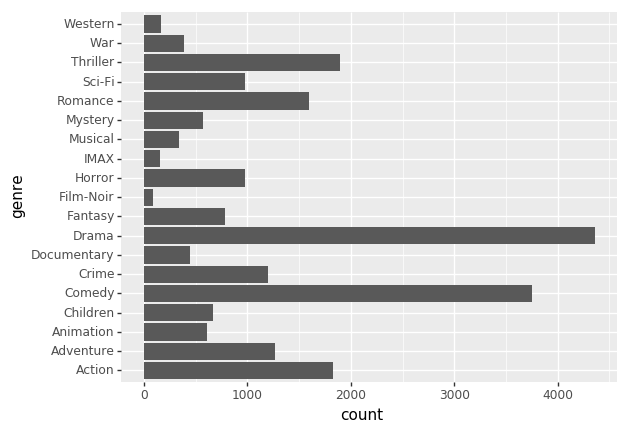

<ggplot: (8732069755852)>

In [8]:
(
    gg.ggplot(ds.get_genres_df(), gg.aes(x='genre')) 
    + gg.geom_bar()
    + gg.coord_flip()
)

Now we know that Dramaand Comedy is definetly most popular genres. So, we can assign them to the movies without genres. Don't you think that these movies really has no any genres? I don't think so. Anyway, we have only 0.35% of them, so we can place here anything ]:>

In [9]:
ds.df['genres'].fillna(value='Comedy|Drama', inplace=True)

# YEARS

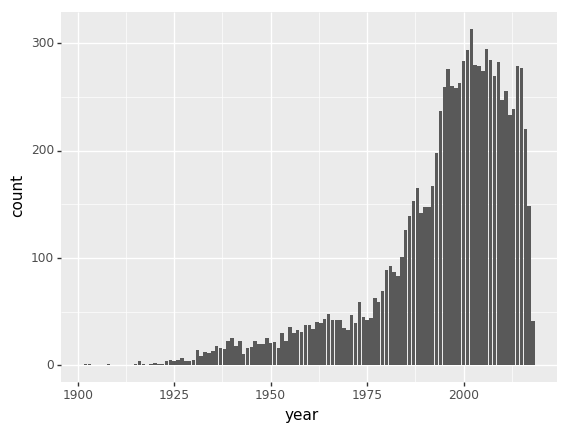

<ggplot: (8732069793663)>

In [10]:
(
    gg.ggplot(ds.df, gg.aes(x='year')) 
    + gg.geom_bar()
)

In [11]:
genres = ds.get_genres_df()

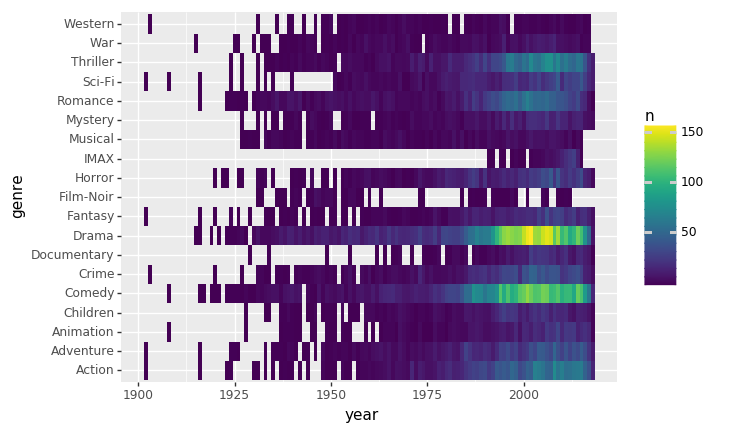

<ggplot: (-9223363304787708598)>

In [12]:
(
    genres
    >> plydata.add_count('year', 'genre')
    >> gg.ggplot(gg.aes(x='year', y='genre', fill='n')) 
    + gg.geom_tile()
)

1. Damn, I want more Westerns and Noirs in my life.
1. I guess, there was much more [Spaghetti-westerns](https://en.wikipedia.org/wiki/List_of_Spaghetti_Western_films), they just not listed in this database. And this is good, nobody wants to watch westerns without Clint Eastwood.
1. Noir never was really popular.
1. We get sci-fi as genre in 50-s. This is time when computers start make science not only for WW2, I guess.
1. IMAX was very seasoned genre. Who really can say "Wow, IMAX is my favorite genre"?
1. Musicals also not so popular in last years. In The Netherlands and other Europeian countries most of movies goes with subtitles, but in Russia and other [CIS](https://en.wikipedia.org/wiki/Commonwealth_of_Independent_States) countries 99% of films has [Dubbing](https://en.wikipedia.org/wiki/Dubbing_(filmmaking)). So, there you never can find great musicals in the cinema theaters.
1. Thriller, Romance, Drama, Comedy, Adventure and Action raised in 00-s.

Why am I research this? I don't think that this can help us to build recommendation system algorithms, of course. However, this information is really interesting, isn't it?

# RATING

In [13]:
movies = ds
ratings = RatingData()

We can't just join `genres` and `ratings`, I guess, because it will be really huge dataframe. Let's eat cake by pieces. First one, I want have a look on rating of every genre by every year.

In [14]:
genres['rating'] = genres['movie'].apply(
    lambda movie_id: ratings.df[ratings.df['movieId'] == movie_id].rating.mean(),
)

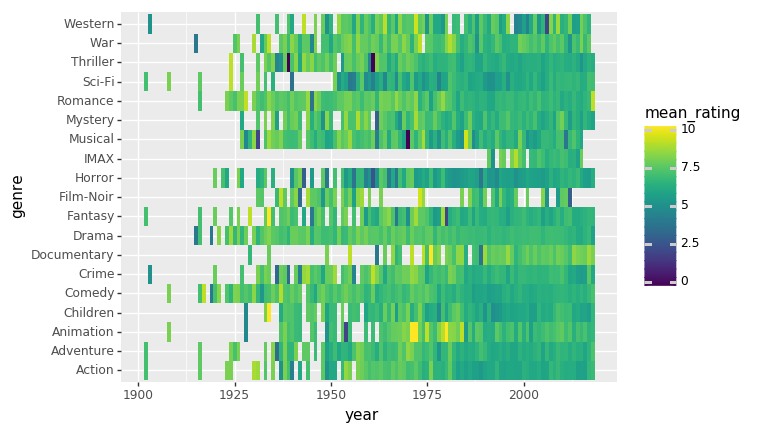

<ggplot: (-9223363304784880345)>

In [15]:
(
    genres
    >> plydata.group_by('year', 'genre')
    >> plydata.summarize(mean_rating='sum(rating) / len(rating)')
    >> gg.ggplot(gg.aes(x='year', y='genre', fill='mean_rating')) 
    + gg.geom_tile()
)

Hmmm... Do you see correlations? Let's try to get something from this.

1. Some **westerns** are good, some of westerns are bad. Some of westerns are ugly :) I guess, they has big deviation. We will look closer on deviation on the next charts.
1. **Sci-Fi** movies becomes better.
1. People value **Animation** and **Documentary**. Wow.
1. **Animation** was much better rated in 70-s
1. **Documentaries** of the last years are good.
1. **Horror** movies never get good rating. Ok, I personally like "The Silence of the Lambs" and "Se7en", and the have a good rating, but this is not really horrors.


/home/gram/.local/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_boxplot : Removed 38 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


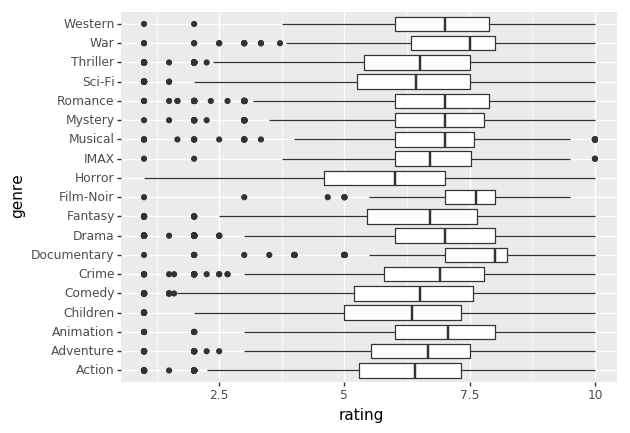

<ggplot: (8732067453602)>

In [16]:
(
    gg.ggplot(genres, gg.aes(x='genre', y='rating')) 
    + gg.geom_boxplot()
    + gg.coord_flip()
)

1. Yeah, **Horror** is the worst rated genre.
1. **Documentary** is the best rated genre. What is your favorite Documentary movie? I personally don't really like this genre, but "A Beautiful Mind" is quite good. However, they almost not talk about value of John Nash's research for all Game theory.
1. We can't really discuss deviation on this step, because there we already operates by mean rating for every movie. However, we can guess that **Noir** movies has quite low deviation: most of movies in this genre rated on 7-8.

In [17]:
genres['rating_std'] = genres['movie'].apply(
    lambda movie_id: ratings.df[ratings.df['movieId'] == movie_id].rating.std(),
)

/home/gram/.local/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_boxplot : Removed 7137 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


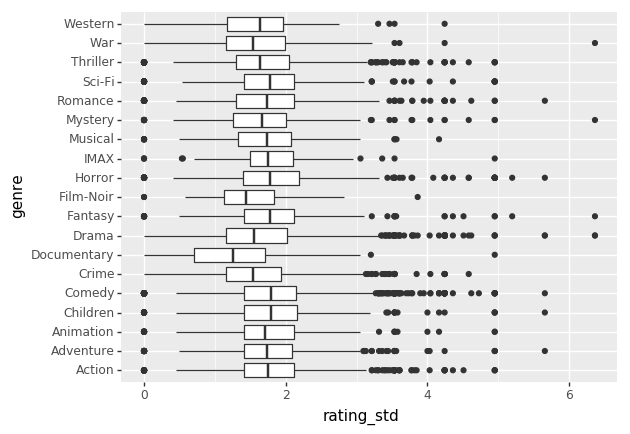

<ggplot: (8732067350006)>

In [18]:
(
    gg.ggplot(genres)
    + gg.geom_boxplot(gg.aes(x='genre', y='rating_std'))
    + gg.coord_flip()
)

1. **Documentary** has the lowest deviation in movies ratings.
1. Most ambiguous genre is **Sci-Fi**.
1. We have some really ambiguous movies. Lets look on them.

In [19]:
movies.df['rating'] = movies.df.reset_index()['movieId'].apply(
    lambda movie_id: ratings.df[ratings.df['movieId'] == movie_id].rating.mean(),
)

movies.df['rating_std'] = movies.df.reset_index()['movieId'].apply(
    lambda movie_id: ratings.df[ratings.df['movieId'] == movie_id].rating.std(),
)

movies.df['rating_count'] = movies.df.reset_index()['movieId'].apply(
    lambda movie_id: ratings.df[ratings.df['movieId'] == movie_id].rating.count(),
)


In [20]:
print('Most popular movies')
movies.df.sort_values('rating_count', ascending=False).head()

Most popular movies


,title,genres,year,rating,rating_std,rating_count
movieId,,,,,,
314,"Secret of Roan Inish, The (1994)",Children|Drama|Fantasy|Mystery,1994.0,8.328267,1.662487,329.0
277,Miracle on 34th Street (1994),Drama,1994.0,8.858044,1.426037,317.0
257,Just Cause (1995),Mystery|Thriller,1995.0,8.394137,1.903994,307.0
510,Poetic Justice (1993),Drama,1993.0,8.322581,1.707967,279.0
1939,"Best Years of Our Lives, The (1946)",Drama|War,1946.0,8.384892,1.950485,278.0


In [21]:
print('Best movies')
movies.df[movies.df['rating_count'] > 30].sort_values('rating', ascending=False).head()

Best movies


,title,genres,year,rating,rating_std,rating_count
movieId,,,,,,
277,Miracle on 34th Street (1994),Drama,1994.0,8.858044,1.426037,317.0
906,Gaslight (1944),Drama|Thriller,1944.0,8.600000,1.670601,45.0
2226,"Ring, The (1927)",Drama,1927.0,8.545872,1.722769,218.0
602,"Great Day in Harlem, A (1994)",Documentary,1994.0,8.536082,1.614142,97.0
922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,1950.0,8.519380,1.606144,129.0


In [22]:
print('Worst movies')
movies.df[movies.df['rating_count'] > 30].sort_values('rating', ascending=True).head()

Worst movies


,title,genres,year,rating,rating_std,rating_count
movieId,,,,,,
1373,Star Trek V: The Final Frontier (1989),Action|Sci-Fi,1989.0,3.909091,1.683813,33.0
1235,Harold and Maude (1971),Comedy|Drama|Romance,1971.0,4.218750,1.979481,32.0
2860,Blue Streak (1999),Comedy,1999.0,4.589744,2.035448,39.0
313,"Swan Princess, The (1994)",Animation|Children,1994.0,4.714286,1.941658,42.0
379,Timecop (1994),Action|Sci-Fi|Thriller,1994.0,4.841270,2.141799,63.0


In [23]:
print('Most ambiguous movies')
movies.df[movies.df['rating_count'] > 30].sort_values('rating_std', ascending=False).head()

Most ambiguous movies


,title,genres,year,rating,rating_std,rating_count
movieId,,,,,,
1826,Barney's Great Adventure (1998),Adventure|Children,1998.0,6.600000,2.830506,35.0
2035,Blackbeard's Ghost (1968),Children|Comedy,1968.0,5.593750,2.747112,64.0
140,Up Close and Personal (1996),Drama|Romance,1996.0,6.166667,2.597168,54.0
973,Meet John Doe (1941),Comedy|Drama,1941.0,7.487179,2.543017,39.0
1081,Victor/Victoria (1982),Comedy|Musical|Romance,1982.0,5.870968,2.486523,31.0


1. Someday I analyzed IMDB dump and on IMDB most ambiguous movie was "Dumb & Dumber". This is awful movie, IMHO >.<
1. [OH GUSH MY EYES](https://youtu.be/Os3LM2MTKr4?t=1520)

In [24]:
print('Least ambiguous movies')
movies.df[movies.df['rating_count'] > 30].sort_values('rating_std', ascending=True).head()

Least ambiguous movies


,title,genres,year,rating,rating_std,rating_count
movieId,,,,,,
8879,Murder on the Orient Express (1974),Crime|Mystery|Thriller,1974.0,8.000000,1.148542,48.0
4526,My Stepmother Is an Alien (1988),Comedy|Romance|Sci-Fi,1988.0,7.441176,1.159707,34.0
2462,Texas Chainsaw Massacre: The Next Generation (...,Horror,1994.0,8.441860,1.160918,43.0
4795,Father Goose (1964),Adventure|Comedy|Romance|War,1964.0,7.806452,1.185136,62.0
7647,Noises Off... (1992),Comedy,1992.0,7.967742,1.196770,31.0


Of course, 20M dump would be more informative, but I have no resources for it yet.

/home/gram/.local/lib/python3.7/site-packages/plotnine/layer.py:449: UserWarning: geom_jitter : Removed 38 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


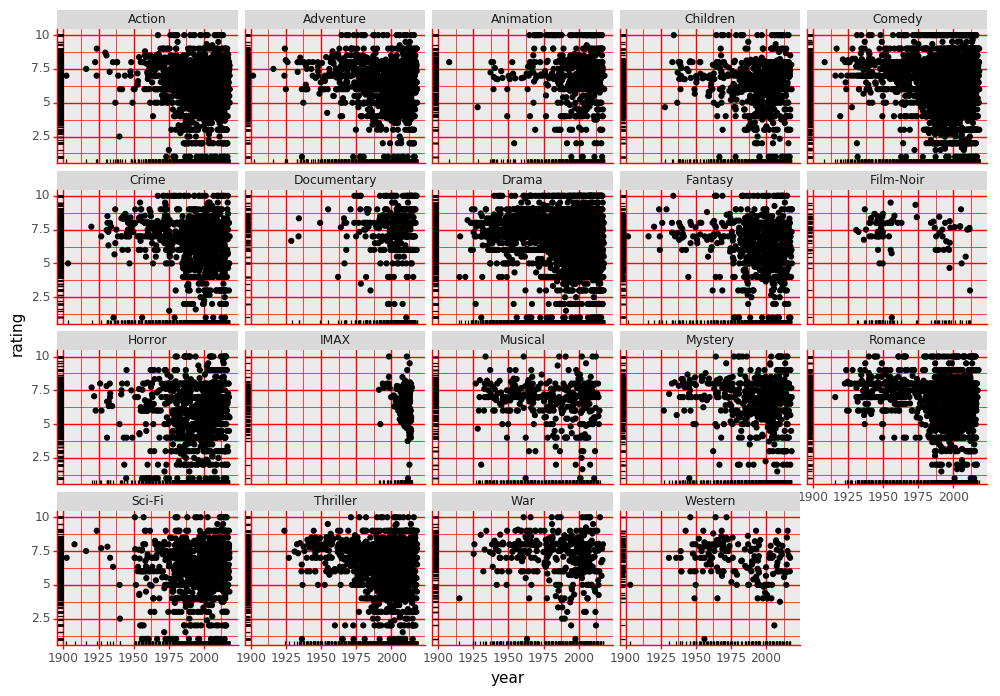

<ggplot: (8732064052095)>

In [50]:
(
    gg.ggplot(genres, gg.aes(x='year', y='rating'))
    + gg.geom_jitter(height=0)
    + gg.facet_wrap('~genre')
    + gg.geom_rug()
    + gg.theme(figure_size=(12, 8))
)

1. All old movies in all genres has only mostly good rating. Old bad movies was forgiven.
1. Most of marks is positive.
1. Noir has 2 periods of popularity. Ok, not really popularity.
1. Almost all **Westerns** have rating greater or equal to 4.
1. All old **Sci-Fi** movies high-rated
1. And again: **Horror** movies hasstrong deviation.
1. Old **Musicals** as popular as modern Musicals.
